In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

!pip install bs4 lxml
from bs4 import BeautifulSoup
import lxml
import requests

print('Libraries imported.')


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Libraries imported.


In [2]:
# Parse the postal codes 
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
# look for all table elements
table = soup.find_all('table')[0] 
dft = pd.read_html(str(table))
df = dft[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# Get names of indexes for which column Borough has is Not assigned
indexNames = df[ df['Borough'] == 'Not assigned' ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
df = df.reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
locdf = pd.read_csv('Geospatial_Coordinates.csv')
locdf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# Add lat,long
df2 = pd.merge(df,locdf, left_on='Postal Code', right_on='Postal Code')
df2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
# get downtown only
downtown_data = df2[df2['Borough'] == 'Downtown Toronto']
downtown_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [7]:
# drop PO boxes
downtown_data = downtown_data[downtown_data.Neighbourhood != 'Stn A PO Boxes']
downtown_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [8]:
VERSION = '20180605' # Foursquare API version

# Read secrets from a file
sdf = pd.read_csv('.env')
CLIENT_ID = sdf['CLIENT_ID'][0]
CLIENT_SECRET = sdf['CLIENT_SECRET'][0]
SITE='https://api.foursquare.com/v2'

In [9]:
# Categories

# Restaurants
Food='4d4b7105d754a06374d81259'
ItalianRestaurants='4bf58dd8d48988d110941735'

# Areas of related interest
PerformingArts='4bf58dd8d48988d1f2931735'
MovieTheater='4bf58dd8d48988d17f941735'
ArtMuseum='4bf58dd8d48988d18f941735'
ArtGallery='4bf58dd8d48988d1e2931735'
MusicVenue='4bf58dd8d48988d1e5931735'

NightLifeSpot='4d4b7105d754a06376d81259'

Bars = {
    'WineBar':'4bf58dd8d48988d123941735',
    'SportsBar':'4bf58dd8d48988d11d941735',
    'WhiskyBar':'4bf58dd8d48988d122941735',
    'Pub':'4bf58dd8d48988d11b941735',
    'Speakeasy':'4bf58dd8d48988d1d4941735',
    'BeerBar':'56aa371ce4b08b9a8d57356c',
    'ChampagneBar':'52e81612bcbc57f1066b7a0e',
    'CocktailBar':'4bf58dd8d48988d11e941735',
    'HotelBar':'4bf58dd8d48988d1d5941735',
}

In [10]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, categories, radius=500,):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = '{}/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            SITE,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categories
        )
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        #return results
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
downtown_venues = getNearbyVenues(
    names=downtown_data['Neighbourhood'],
    latitudes=downtown_data['Latitude'],
    longitudes=downtown_data['Longitude'],
    categories=ItalianRestaurants                                                                  
                                  )
#len(downtown_venues)
#downtown_venues
downtown_venues.shape

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


(163, 7)

In [12]:
downtown_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Gusto 501,43.654810,-79.359595,Italian Restaurant
1,"Regent Park, Harbourfront",43.654260,-79.360636,Massimo's Kitchen Studio,43.654770,-79.359698,Italian Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Massimo Bruno Supper Club,43.654763,-79.359511,Italian Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,Fusilli,43.657188,-79.357095,Italian Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Basso,43.655532,-79.365071,Pizza Place
5,"Regent Park, Harbourfront",43.654260,-79.360636,Archeo,43.650667,-79.359431,Italian Restaurant
6,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
7,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Tosto,43.661198,-79.386414,Italian Restaurant
8,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Pastacceria,43.660020,-79.388188,Italian Restaurant
9,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Hornero,43.664096,-79.384038,Italian Restaurant


In [13]:
# remove cafes,bakeries and pizza places
downtown_venues = downtown_venues[downtown_venues['Venue Category'] == 'Italian Restaurant']
downtown_venues.shape

(137, 7)

In [14]:
downtown_venues.groupby(['Neighbourhood']).count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,8,8,8,8,8,8
Central Bay Street,10,10,10,10,10,10
Christie,2,2,2,2,2,2
Church and Wellesley,3,3,3,3,3,3
"Commerce Court, Victoria Hotel",23,23,23,23,23,23
"First Canadian Place, Underground city",16,16,16,16,16,16
"Garden District, Ryerson",9,9,9,9,9,9
"Harbourfront East, Union Station, Toronto Islands",6,6,6,6,6,6
"Kensington Market, Chinatown, Grange Park",2,2,2,2,2,2


In [15]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
df3 = downtown_venues[['Neighbourhood','Venue Category']]
d4 = df3.groupby(['Neighbourhood']).count()
d4.sort_values(by=['Venue Category'],inplace=True)

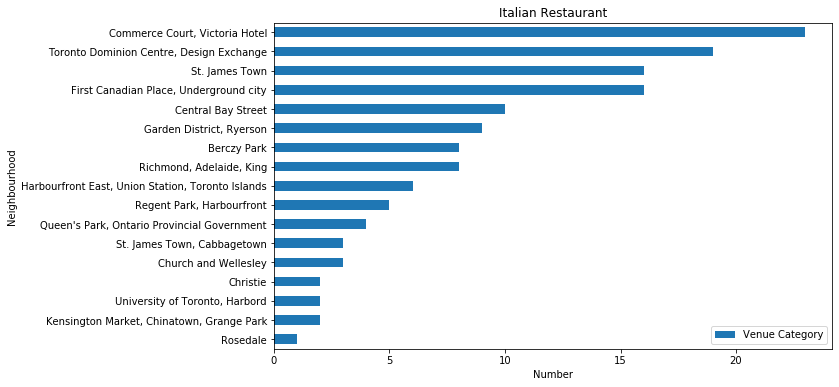

In [66]:
#plt.plot(downtown_venues['Venue Category'],kind='bar', figsize=(10, 6)) # rotate the bars by 90 degrees
#downtown_venues[['Neighbourhood','Venue Category']].plot(kind='bar')
#plt.plot(downtown_venues['Venue Category'])
d4.plot(kind='barh', figsize=(10, 6))
plt.ylabel('Neighbourhood')
plt.xlabel('Number')
plt.title('Italian Restaurant')
plt.show()

In [18]:
d4.head()

,Venue Category
Neighbourhood,
Rosedale,1
"Kensington Market, Chinatown, Grange Park",2
"University of Toronto, Harbord",2
Christie,2
Church and Wellesley,3


In [19]:
downtown_life = getNearbyVenues(
    names=downtown_data['Neighbourhood'],
    latitudes=downtown_data['Latitude'],
    longitudes=downtown_data['Longitude'],
    categories=NightLifeSpot                                                                  
                                  )
#len(downtown_venues)
#downtown_venues
downtown_life.shape

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


(656, 7)

In [20]:
downtown_life

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Henrietta Lane,43.653911,-79.361395,Cocktail Bar
1,"Regent Park, Harbourfront",43.654260,-79.360636,suáh,43.655935,-79.356245,Karaoke Bar
2,"Regent Park, Harbourfront",43.654260,-79.360636,ODIN Cafe + Bar,43.656739,-79.356503,Café
3,"Regent Park, Harbourfront",43.654260,-79.360636,Cosmic Karma,43.652788,-79.360739,Bar
4,"Regent Park, Harbourfront",43.654260,-79.360636,Dubble Apple,43.655985,-79.363556,Hookah Bar
5,"Regent Park, Harbourfront",43.654260,-79.360636,The Aviary,43.653634,-79.354662,Pub
6,"Regent Park, Harbourfront",43.654260,-79.360636,Martini Club,43.650597,-79.359789,Event Space
7,"Regent Park, Harbourfront",43.654260,-79.360636,Biergarten,43.650413,-79.358752,Beer Garden
8,"Regent Park, Harbourfront",43.654260,-79.360636,Stirling Room,43.650644,-79.359829,Lounge
9,"Regent Park, Harbourfront",43.654260,-79.360636,The Boiler Room,43.650844,-79.358813,Other Nightlife


In [21]:
dn3 = downtown_life[['Neighbourhood','Venue Category']]
dn4 = dn3.groupby(['Neighbourhood']).count()
dn4.sort_values(by=['Venue Category'],inplace=True)

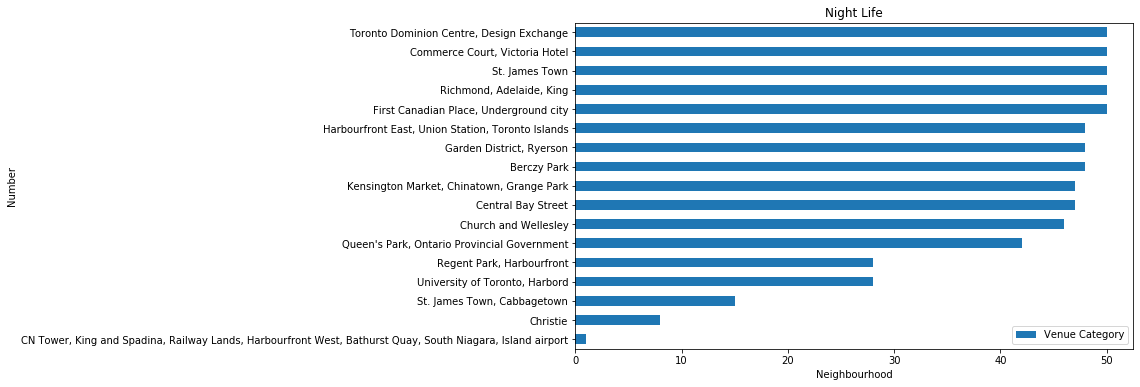

In [22]:
#plt.plot(downtown_venues['Venue Category'],kind='bar', figsize=(10, 6)) # rotate the bars by 90 degrees
#downtown_venues[['Neighbourhood','Venue Category']].plot(kind='bar')
#plt.plot(downtown_venues['Venue Category'])
dn4.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Neighbourhood')
plt.ylabel('Number')
plt.title('Night Life')
plt.show()

In [23]:
dn4.tail(10)

,Venue Category
Neighbourhood,
Central Bay Street,47
"Kensington Market, Chinatown, Grange Park",47
Berczy Park,48
"Garden District, Ryerson",48
"Harbourfront East, Union Station, Toronto Islands",48
"First Canadian Place, Underground city",50
"Richmond, Adelaide, King",50
St. James Town,50
"Commerce Court, Victoria Hotel",50


In [24]:
d4.head(10)

,Venue Category
Neighbourhood,
Rosedale,1
"Kensington Market, Chinatown, Grange Park",2
"University of Toronto, Harbord",2
Christie,2
Church and Wellesley,3
"St. James Town, Cabbagetown",3
"Queen's Park, Ontario Provincial Government",4
"Regent Park, Harbourfront",5
"Harbourfront East, Union Station, Toronto Islands",6


In [25]:
downtown_food = getNearbyVenues(
    names=downtown_data['Neighbourhood'],
    latitudes=downtown_data['Latitude'],
    longitudes=downtown_data['Longitude'],
    categories=Food                                                         
                                  )
downtown_food.shape

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


(783, 7)

In [26]:
dd3 = downtown_food[['Neighbourhood','Venue Category']]
dd4 = dd3.groupby(['Neighbourhood']).count()
dd4.sort_values(by=['Venue Category'],inplace=True)

In [27]:
dd4.head()

,Venue Category
Neighbourhood,
Rosedale,3
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",4
Christie,27
"University of Toronto, Harbord",49
"St. James Town, Cabbagetown",50


In [28]:
result = pd.merge(d4, dd4, on='Neighbourhood')
result.columns = ['Italian Restaurant','Restaurants']
result

,Italian Restaurant,Restaurants
Neighbourhood,,
Rosedale,1,3
"Kensington Market, Chinatown, Grange Park",2,50
"University of Toronto, Harbord",2,49
Christie,2,27
Church and Wellesley,3,50
"St. James Town, Cabbagetown",3,50
"Queen's Park, Ontario Provincial Government",4,50
"Regent Park, Harbourfront",5,50
"Harbourfront East, Union Station, Toronto Islands",6,50


In [29]:
result = pd.merge(result, dn4, on='Neighbourhood')
#result.columns = ['Italian Restaurant','Nightlife']
result.rename(columns={'Venue Category':'Nightlife'}, inplace=True)
result

,Italian Restaurant,Restaurants,Nightlife
Neighbourhood,,,
"Kensington Market, Chinatown, Grange Park",2,50,47
"University of Toronto, Harbord",2,49,28
Christie,2,27,8
Church and Wellesley,3,50,46
"St. James Town, Cabbagetown",3,50,15
"Queen's Park, Ontario Provincial Government",4,50,42
"Regent Park, Harbourfront",5,50,28
"Harbourfront East, Union Station, Toronto Islands",6,50,48
"Richmond, Adelaide, King",8,50,50


In [30]:
result.sort_values(by=['Italian Restaurant'],inplace=True)
result.head(10)

,Italian Restaurant,Restaurants,Nightlife
Neighbourhood,,,
"Kensington Market, Chinatown, Grange Park",2,50,47
"University of Toronto, Harbord",2,49,28
Christie,2,27,8
Church and Wellesley,3,50,46
"St. James Town, Cabbagetown",3,50,15
"Queen's Park, Ontario Provincial Government",4,50,42
"Regent Park, Harbourfront",5,50,28
"Harbourfront East, Union Station, Toronto Islands",6,50,48
"Richmond, Adelaide, King",8,50,50


In [90]:
newdf = result.loc[(result.Restaurants > 30) & (result.Nightlife > 30)]
#newdf
#result.columns
newdf

,Italian Restaurant,Restaurants,Nightlife
Neighbourhood,,,
"Kensington Market, Chinatown, Grange Park",2,50,47
Church and Wellesley,3,50,46
"Queen's Park, Ontario Provincial Government",4,50,42
"Harbourfront East, Union Station, Toronto Islands",6,50,48
"Richmond, Adelaide, King",8,50,50
Berczy Park,8,50,48
"Garden District, Ryerson",9,50,48
Central Bay Street,10,50,47
"First Canadian Place, Underground city",16,50,50


In [67]:

#newdf.reset_index(drop=True)

#newdf.reset_index(level=0, inplace=True)
#cols = [newdf['Restaurants'],newdf['Italian Restaurant']]
#newdf['Total'] = newdf['Restaurants'] - newdf['Italian Restaurant']
#newdf

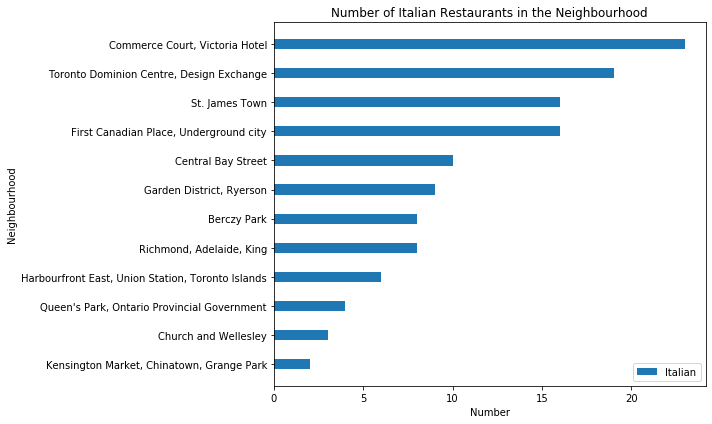

In [115]:
#labels = newdf['Neighbourhood'].to_list()
labels = newdf.index.values.tolist() 
ir = newdf['Italian Restaurant'].to_list()
#r = newdf['Total'].to_list()

width = 0.35       # the width of the bars: can also be len(x) sequence

#fig = plt.figure(figsize=(14,10))
fig,ax = plt.subplots(figsize=(10,6))

ax.barh(labels, ir, width, label='Italian')
#ax.barh(labels, r, width, left=ir,
#       label='All')
#ax.barh(np.arange(len(ir)), ir, height=width)
#ax.barh(np.arange(len(r)) + width, r, height=width)

ax.set_ylabel('Neighbourhood')
ax.set_xlabel('Number')
ax.set_title('Number of Italian Restaurants in the Neighbourhood')
ax.legend()
plt.tight_layout()
plt.show()

fig.savefig('plot3.png')

In [74]:
#downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#downtown_merged.head()

downtown_merged = pd.merge(newdf, downtown_data, on='Neighbourhood')
#result.columns = ['Italian Restaurant','Nightlife']
#result.rename(columns={'Venue Category':'Nightlife'}, inplace=True)
#result
downtown_merged

,Neighbourhood,Italian Restaurant,Restaurants,Nightlife,Postal Code,Borough,Latitude,Longitude
0,"Kensington Market, Chinatown, Grange Park",2,50,47,M5T,Downtown Toronto,43.653206,-79.400049
1,Church and Wellesley,3,50,46,M4Y,Downtown Toronto,43.665860,-79.383160
2,"Queen's Park, Ontario Provincial Government",4,50,42,M7A,Downtown Toronto,43.662301,-79.389494
3,"Harbourfront East, Union Station, Toronto Islands",6,50,48,M5J,Downtown Toronto,43.640816,-79.381752
4,"Richmond, Adelaide, King",8,50,50,M5H,Downtown Toronto,43.650571,-79.384568
5,Berczy Park,8,50,48,M5E,Downtown Toronto,43.644771,-79.373306
6,"Garden District, Ryerson",9,50,48,M5B,Downtown Toronto,43.657162,-79.378937
7,Central Bay Street,10,50,47,M5G,Downtown Toronto,43.657952,-79.387383
8,"First Canadian Place, Underground city",16,50,50,M5X,Downtown Toronto,43.648429,-79.382280
9,St. James Town,16,50,50,M5C,Downtown Toronto,43.651494,-79.375418


In [73]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [87]:
# create map
latitude = 43.6532
longitude = -79.3832
loc_map = folium.Map(location=[latitude, longitude], zoom_start=14)


# add markers to the map
markers_colors = []
for lat, lon, poi, cnt in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighbourhood'],downtown_merged['Italian Restaurant']):
    label = folium.Popup(str(poi), parse_html=True)
    if cnt > 5: 
        color = 'Blue'
    else:
        color = 'Red'
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=poi,
        color= color, # rainbow[cluster-1],
        fill=True,
        fill_color=  color, #rainbow[cluster-1],
        fill_opacity=0.7).add_to(loc_map)
    #print(poi)
loc_map